Ahora hacemos un análisis de correlación de las variables. Como hay variables numéricas y categóricas, haremos distintos análisis:

Primero analizaremos la correlación entre variables numéricas.

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv("data_stored.csv")

# Usamos solo las variables numéricas
categ = ['CUS', 'OC']
numericas = data.drop(columns=categ, errors='ignore')

# Excluir las coordenadas
coord = ['POINT_X', 'POINT_Y']
numericas = numericas.drop(columns=coord, errors='ignore')

# Matriz de correlación
matriz_cor = numericas.corr()
print("Matriz de correlación:")
print(matriz_cor)

Matriz de correlación:
            PLA         A        AC       CIB     CICCB       DBB       DOB  \
PLA    1.000000  0.213086 -0.227800  0.412452 -0.045163 -0.245722 -0.446663   
A      0.213086  1.000000 -0.338053  0.847168  0.494960 -0.141612 -0.522008   
AC    -0.227800 -0.338053  1.000000 -0.322887 -0.193564  0.067180  0.343502   
CIB    0.412452  0.847168 -0.322887  1.000000  0.284885  0.128606 -0.355735   
CICCB -0.045163  0.494960 -0.193564  0.284885  1.000000 -0.363938 -0.319922   
DBB   -0.245722 -0.141612  0.067180  0.128606 -0.363938  1.000000  0.741151   
DOB   -0.446663 -0.522008  0.343502 -0.355735 -0.319922  0.741151  1.000000   
P      0.152295  0.045995 -0.097234 -0.010246  0.016805 -0.089780 -0.080813   

              P  
PLA    0.152295  
A      0.045995  
AC    -0.097234  
CIB   -0.010246  
CICCB  0.016805  
DBB   -0.089780  
DOB   -0.080813  
P      1.000000  


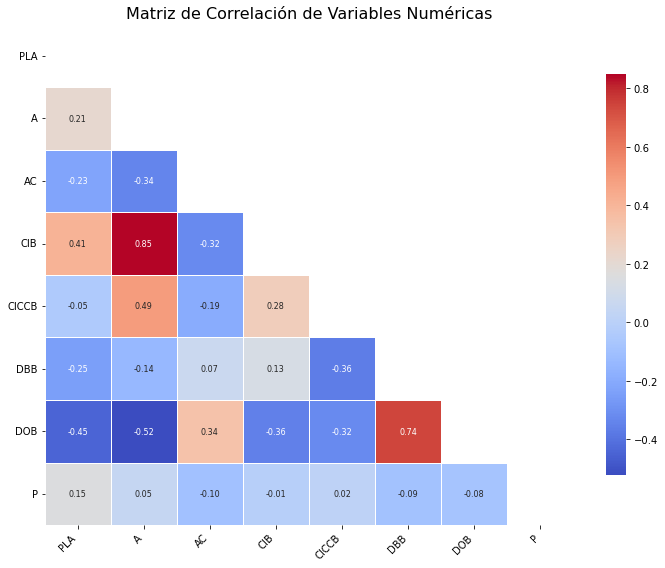

In [10]:
# 3. Visualizar la matriz como heatmap

plt.figure(figsize=(10, 8)) # Ajusta el tamaño de la figura para una mejor visualización

mask = np.triu(np.ones_like(matriz_cor, dtype=bool))

sns.heatmap(matriz_cor, mask=mask, annot=True, cmap='coolwarm', fmt=".2f",
            linewidths=.5, cbar_kws={"shrink": .8}, annot_kws={"size": 8}) # fmt=".2f" para 2 decimales, annot=True para valores
plt.title("Matriz de Correlación de Variables Numéricas", fontsize=16)
plt.xticks(rotation=45, ha='right') # Rotar etiquetas del eje X para mejor legibilidad
plt.yticks(rotation=0) # Asegurarse que etiquetas del eje Y no roten
plt.tight_layout() # Ajustar el diseño para que todo quepa

plt.savefig('heatmap_correlacion.png', bbox_inches='tight', dpi=300)
plt.show()


Vemos que las variables A y CIB tienen una correlación mayor a 80%, y que DBB y DOB tienen una correlación mayor al 70%. 

Ahora queremos ver si las variables categóricas están correlacionadas entre sí. Esto no puede hacerse directamente, entonces se hace un test de Cramer's V, que mide la fuerza de asociación entre dos variables categóricas. El valor varía entre 0 (sin asociación) y 1 (asociación total).

In [11]:
from scipy.stats import chi2_contingency # Para el test de chi-cuadrado

categoricas = data[["CUS", "OC"]]

def cramers_v(x, y):
        confusion_matrix = pd.crosstab(x, y)
        chi2, p_val, dof, expected = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        r, k = confusion_matrix.shape
        min_dim = min(k - 1, r - 1)
        if n == 0 or min_dim == 0:
            return 0.0
        phi2 = chi2 / n
        v = np.sqrt(phi2 / min_dim)
        return v

cramer_v_result = cramers_v(categoricas['CUS'], categoricas['OC'])
print(f"Cramér's V entre CUS y OC: {cramer_v_result:.4f}")


Cramér's V entre CUS y OC: 0.5047


El resultado muestra una asociación moderada. 

Una vez más, no se puede ver la correlación entre variables categóricas y numéricas, pero se puede comprobar la diferencia de las medias entre grupos. Para ello usamos el test de Kruskal Wallis, que es una versión del ANOVA que no asume normalidad, para variables categóricas de más de dos grupos. 
El test nos indicará el valor de p con la hipótesis de que las medias (de una variable numérica) entre los grupos de la variable categórica son diferentes. Esto nos indica si el hecho de pertenecer a un grupo o a otro afecta a la variable numérica.

In [14]:
from scipy.stats import kruskal


kruskal_results = {}


def get_kruskal_pvalue(df, cat_col, num_col):
    """
    Prepara los datos y ejecuta el test de Kruskal-Wallis para un par de variables.
    Retorna el p-valor o np.nan si el test no se puede realizar.
    """
    # Nos aseguramos de que la variable categórica tenga al menos 2 grupos únicos.
    # Ya que el usuario indica que los datos están limpios, no necesitamos un .dropna() global aquí,
    # pero sí para asegurarnos que cada grupo sea no vacío al pasarlo a kruskal.
    unique_categories = df[cat_col].unique()

    # Si hay menos de 2 categorías únicas, el test no tiene sentido.
    if len(unique_categories) < 2:
        return np.nan

    # Preparamos los datos numéricos agrupados por categoría.
    # kruskal requiere cada grupo como un argumento separado.
    # El .dropna() aquí es para asegurar que los arrays pasados a kruskal no contengan NaNs
    # dentro de los grupos, aunque los datos principales se asuman limpios.
    groups_data = [df[num_col][df[cat_col] == category].dropna().values
                   for category in unique_categories]

    # Filtramos grupos que puedan haber quedado vacíos después de la extracción y el dropna()
    valid_groups = [group for group in groups_data if len(group) > 0]

    # Kruskal-Wallis necesita al menos 2 grupos con datos
    if len(valid_groups) < 2:
        return np.nan

    try:
        # Ejecutamos el test de Kruskal-Wallis. El '*' desempaqueta la lista 'valid_groups'.
        stat, p_value = kruskal(*valid_groups)
        return p_value
    except ValueError as e:
        # Captura errores comunes (ej. si todos los valores en un grupo son idénticos)
        # print(f"  Error interno de scipy.kruskal para {cat_col} vs {num_col}: {e}")
        return np.nan # Retornamos NaN en caso de error para indicar que no se pudo calcular

# Bucle principal para ejecutar el test en todas las combinaciones
for cat_var in categoricas:
    # Comprobación de que la variable categórica es válida para agrupar
    # (ej. tiene más de un valor único en el DataFrame original)
    if data[cat_var].nunique() < 2:
        print(f"Advertencia: '{cat_var}' tiene menos de 2 grupos únicos. Saltando tests con esta variable.")
        continue

    for num_var in numericas:
        p_val = get_kruskal_pvalue(data, cat_var, num_var)

        if not np.isnan(p_val):
            kruskal_results[f"{cat_var}_{num_var}"] = p_val
            print(f"  {cat_var} vs {num_var} (p-valor): {p_val}")
        else:
            print(f"  {cat_var} vs {num_var}: No se pudo calcular el p-valor (ver advertencias anteriores o datos insuficientes).")

# Mostrar resultados finales
print("\n--- Resumen de los p-valores del test de Kruskal-Wallis ---")
if kruskal_results:
    for key, p_val in kruskal_results.items():
        print(f"{key}: {p_val}")
else:
    print("No se pudieron realizar tests de Kruskal-Wallis o no hay resultados para mostrar.")

    

  CUS vs PLA (p-valor): 0.0
  CUS vs A (p-valor): 0.0
  CUS vs AC (p-valor): 0.0
  CUS vs CIB (p-valor): 0.0
  CUS vs CICCB (p-valor): 0.0
  CUS vs DBB (p-valor): 0.0
  CUS vs DOB (p-valor): 0.0
  CUS vs P (p-valor): 0.0
  OC vs PLA (p-valor): 1.9880815731980193e-188
  OC vs A (p-valor): 9.361054130011793e-267
  OC vs AC (p-valor): 0.0
  OC vs CIB (p-valor): 2.477834905697384e-285
  OC vs CICCB (p-valor): 0.0
  OC vs DBB (p-valor): 0.0
  OC vs DOB (p-valor): 0.0
  OC vs P (p-valor): 3.04041302107352e-225

--- Resumen de los p-valores del test de Kruskal-Wallis ---
CUS_PLA: 0.0
CUS_A: 0.0
CUS_AC: 0.0
CUS_CIB: 0.0
CUS_CICCB: 0.0
CUS_DBB: 0.0
CUS_DOB: 0.0
CUS_P: 0.0
OC_PLA: 1.9880815731980193e-188
OC_A: 9.361054130011793e-267
OC_AC: 0.0
OC_CIB: 2.477834905697384e-285
OC_CICCB: 0.0
OC_DBB: 0.0
OC_DOB: 0.0
OC_P: 3.04041302107352e-225


El resultado nos muestra el valor de p para el test, el cual es bajísimo para todas las comparaciones. Esto indica si hay una diferencia significativa entre las medianas de las variables numéricas en los diferentes grupos de las variables categóricas. Si el valor de p es pequeño (por lo general, menor a 0.05), se concluye que hay una diferencia significativa entre los grupos. Vemos que el valor de p es significativamente pequeño para todas las combinaciones de variables. Esto indica que la distribución de la variable numérica cambia significativamente entre los grupos de la variable categórica. Por lo tanto es útil tener todas las variables categóricas en el modelo.


Por lo tanto, sabemos que las variables A y CIB tienen una correlación mayor a 80%, y que DBB y DOB tienen una correlación mayor al 70%, que CUS y OC tienen entre sí una asociación moderada, y que CUS y OC están asociadas de forma significativa a todas las variables numéricas.